## Goal

With this project I will try to train a neural network to predict whether the stock market closing index S&P 500 will rise or fall on a particular date, based on most recent previous values and other stock markets around the world (where some markets close earlier that day because of time difference).

- All Ords (Australlia), closing EST= 01am
- Nikkei 225 (Japan), closing EST= 02am
- Hang Seng (Hong Kong), closing EST= 04am
- DAX (Germany), closing EST= 11:30am
- NYSE Composite (US), closing EST= 04pm
- Dow Jones Industrial Average (US), closing EST= 04pm
- S&P 500 (US), closing EST= 04pm

We can use closing price of All Ords, Nikkei 225, Hang Seng and DAX to predict closing price of S&P 500 on the same day, since they close earlier.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import functools
import math

# Step 1: Prepare data

## I. Load data
Load the local data saved in projectfolder in folder data.
Data is csv file comes from Yahoo Finance.

In [2]:
def read_csv(path):
    return pd.read_csv(path, index_col=[0],
                       dtype={'Open': np.float64, 'High': np.float64, 'Low': np.float64,
                              'Close': np.float64, 'Adj Close': np.float64,'Volume': np.float64}
                      )

In [3]:
data_aus_aord = read_csv('data/^AORD.csv')
data_jap_n225 = read_csv('data/^N225.csv')
data_hk_hs = read_csv('data/^HSI.csv')
data_ger_dax = read_csv('data/^GDAXI.csv')
data_us_nyse = read_csv('data/^NYA.csv')
data_us_dji = read_csv('data/^DJI.csv')
data_us_sap = read_csv('data/^GSPC.csv')

## II. Cut only interesting featrues

In [4]:
closing_data = pd.DataFrame()

closing_data['aord_close'] = data_aus_aord['Adj Close']
closing_data['n225_close'] = data_jap_n225['Adj Close']
closing_data['hs_close']   = data_hk_hs['Adj Close']
closing_data['dax_close']  = data_ger_dax['Adj Close']
closing_data['nyse_close'] = data_us_nyse['Adj Close']
closing_data['dji_close']  = data_us_dji['Adj Close']
closing_data['sap_close']  = data_us_sap['Adj Close']

## III. Clean data

In [5]:
# a) Remove unsuitable data (Hang Seng Hong Kong slip down around 18th April 2017)
# closing_data = closing_data.drop([pd.Timestamp('2017-04-18')])

In [6]:
# b) Fill gaps in the data.
closing_data = closing_data.fillna(method='ffill')
closing_data = closing_data.fillna(0)

In [7]:
# observe data
closing_data.describe()

,aord_close,n225_close,hs_close,dax_close,nyse_close,dji_close,sap_close
count,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000
mean,5282.534385,15831.319826,22812.531182,9712.789406,10179.877068,16811.754735,1919.754187
std,407.355325,3250.847907,1842.746560,1514.009670,981.489027,2077.178712,278.404599
min,4106.000000,8365.900391,18542.150391,6387.569824,7590.609863,12542.379883,1334.760010
25%,5084.200195,14325.980469,21743.199219,8613.000000,9571.790039,15464.299805,1697.369995
50%,5347.799805,16173.519531,22866.699219,9734.330078,10431.459961,16994.220703,1983.530029
75%,5551.600098,18435.869141,23744.189453,10737.870117,10890.440430,17985.189453,2101.040039
max,5976.399902,20868.029297,28442.750000,12888.950195,11833.339844,21528.990234,2453.459961


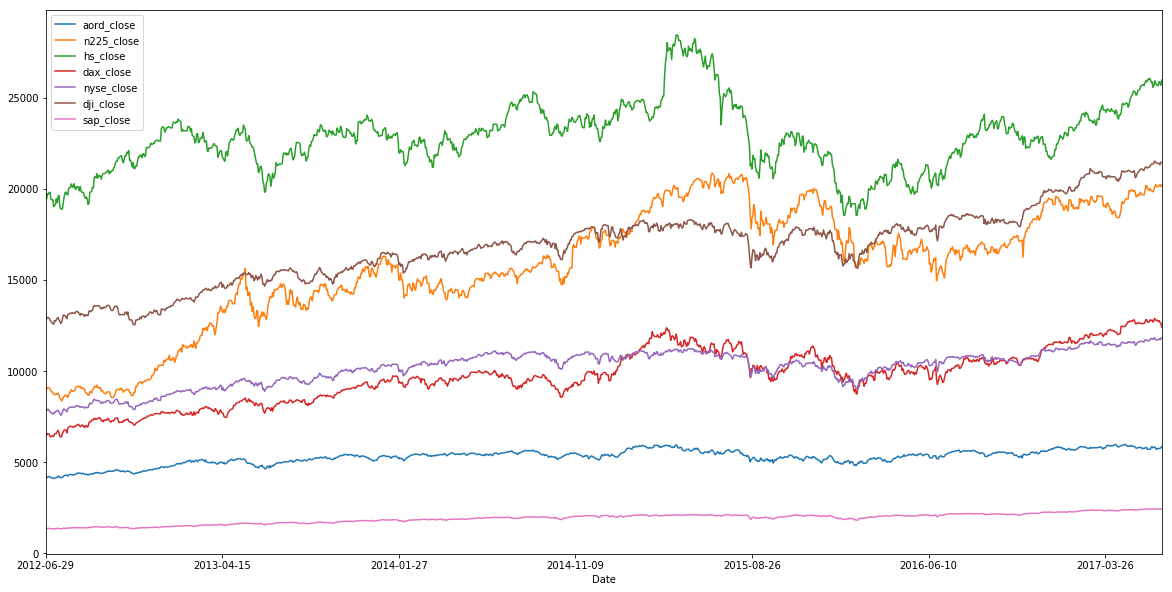

In [8]:
# observe data in graph
_ = closing_data.plot(figsize=(20,10))

# => data needs to be modifiend to fit the same scale

In [9]:
# c) Normalize data to fit the same scale
closing_data_norm = pd.DataFrame()

closing_data_norm['aord_close'] = closing_data['aord_close'] / max(closing_data['aord_close'])
closing_data_norm['n225_close'] = closing_data['n225_close'] / max(closing_data['n225_close'])
closing_data_norm['hs_close']   = closing_data['hs_close']   / max(closing_data['hs_close'])
closing_data_norm['dax_close']  = closing_data['dax_close']  / max(closing_data['dax_close'])
closing_data_norm['nyse_close'] = closing_data['nyse_close'] / max(closing_data['nyse_close'])
closing_data_norm['dji_close']  = closing_data['dji_close']  / max(closing_data['dji_close'])
closing_data_norm['sap_close']  = closing_data['sap_close']  / max(closing_data['sap_close'])

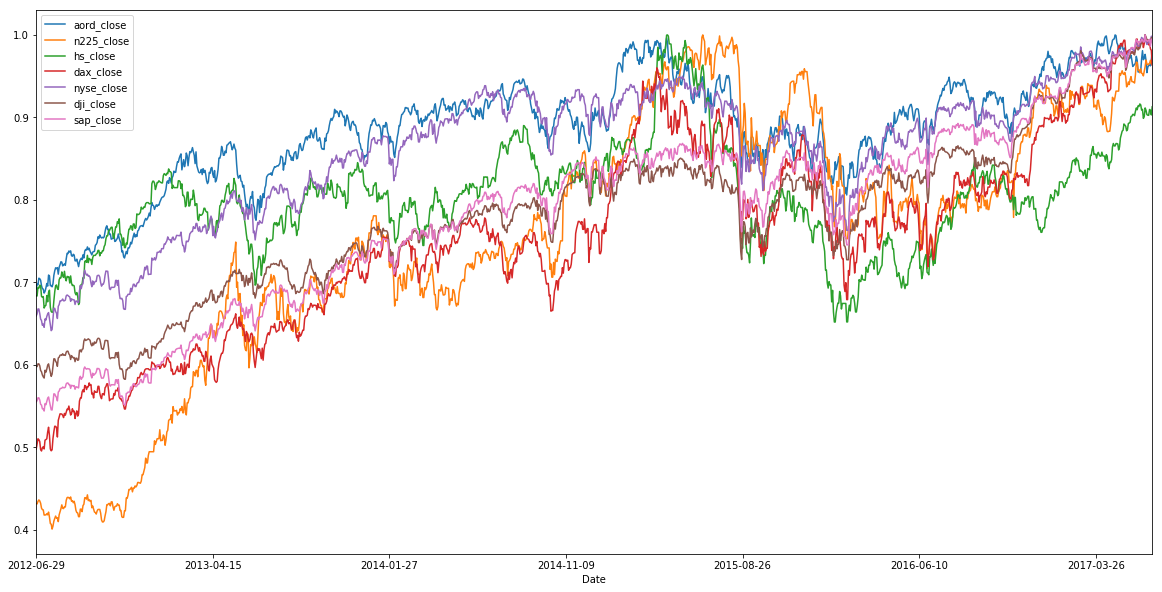

In [10]:
# observe trend in data in graph
_ = closing_data_norm.plot(figsize=(20,10))

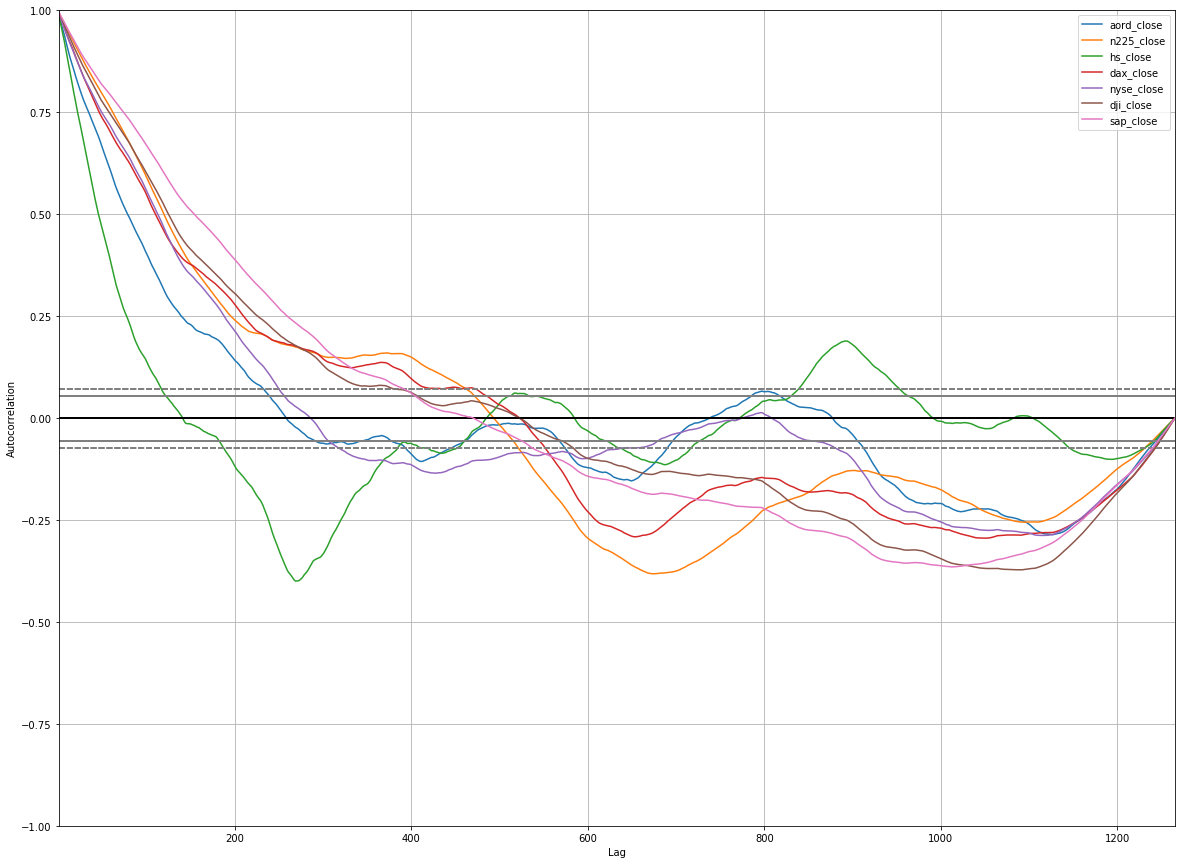

In [11]:
# observe corelations in data in graph
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = pd.plotting.autocorrelation_plot(closing_data_norm['aord_close'], label='aord_close')
_ = pd.plotting.autocorrelation_plot(closing_data_norm['n225_close'], label='n225_close')
_ = pd.plotting.autocorrelation_plot(closing_data_norm['hs_close'], label='hs_close')
_ = pd.plotting.autocorrelation_plot(closing_data_norm['dax_close'], label='dax_close')
_ = pd.plotting.autocorrelation_plot(closing_data_norm['nyse_close'], label='nyse_close')
_ = pd.plotting.autocorrelation_plot(closing_data_norm['dji_close'], label='dji_close')
_ = pd.plotting.autocorrelation_plot(closing_data_norm['sap_close'], label='sap_close')

_ = plt.legend(loc='best')

# => strong corelations in smaller lag (up to ~400 lag), this meand resent past data corelates with upcomming data

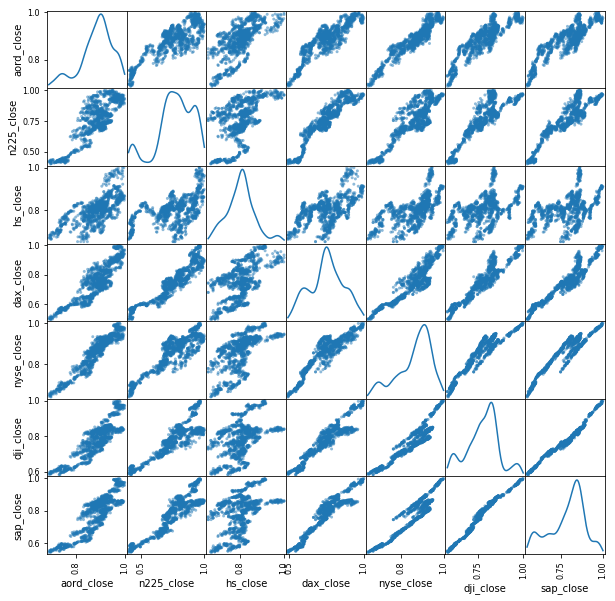

In [12]:
# observe corelations in data in matrix graph
_ = pd.plotting.scatter_matrix(closing_data_norm, figsize=(10, 10), diagonal='kde')

# => we can see there is significant corellation between market indexes on the same day

In [13]:
# make time series data stationary in the mean, thus having no trend in the data
# aplying log(Vt/Vt-1) on all data
closing_data_norm_log = pd.DataFrame()

closing_data_norm_log['aord_close'] = np.log(closing_data['aord_close'] / closing_data['aord_close'].shift())
closing_data_norm_log['n225_close'] = np.log(closing_data['n225_close'] / closing_data['n225_close'].shift())
closing_data_norm_log['hs_close'] = np.log(closing_data['hs_close'] / closing_data['hs_close'].shift())
closing_data_norm_log['dax_close'] = np.log(closing_data['dax_close'] / closing_data['dax_close'].shift())
closing_data_norm_log['nyse_close'] = np.log(closing_data['nyse_close'] / closing_data['nyse_close'].shift())
closing_data_norm_log['dji_close'] = np.log(closing_data['dji_close'] / closing_data['dji_close'].shift())
closing_data_norm_log['sap_close'] = np.log(closing_data['sap_close'] / closing_data['sap_close'].shift())

# remove first row (contains NaN because of the t-1 shift)
closing_data_norm_log = closing_data_norm_log.iloc[1:]
closing_data_norm_log.describe()

,aord_close,n225_close,hs_close,dax_close,nyse_close,dji_close,sap_close
count,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000
mean,0.000275,0.000640,0.000229,0.000522,0.000328,0.000404,0.000461
std,0.008005,0.013703,0.010503,0.011639,0.007906,0.007464,0.007787
min,-0.041143,-0.082529,-0.060183,-0.070673,-0.043961,-0.036402,-0.040211
25%,-0.004367,-0.004281,-0.004102,-0.004412,-0.003109,-0.002545,-0.002587
50%,0.000676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.005059,0.006860,0.005144,0.006160,0.004322,0.004097,0.004430
max,0.032049,0.074262,0.044985,0.050565,0.037549,0.038755,0.038291


# Step 2: Create training/testing dataset

## I. create labels (one-hot encoded)

In [14]:
closing_data_norm_log['sap_rising'] = 0
closing_data_norm_log['sap_falling'] = 0

closing_data_norm_log.loc[closing_data_norm_log['sap_close'] >= 0, 'sap_rising'] = 1
closing_data_norm_log.loc[closing_data_norm_log['sap_close'] < 0, 'sap_falling'] = 1

closing_data_norm_log.describe()

,aord_close,n225_close,hs_close,dax_close,nyse_close,dji_close,sap_close,sap_rising,sap_falling
count,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000
mean,0.000275,0.000640,0.000229,0.000522,0.000328,0.000404,0.000461,0.602057,0.397943
std,0.008005,0.013703,0.010503,0.011639,0.007906,0.007464,0.007787,0.489667,0.489667
min,-0.041143,-0.082529,-0.060183,-0.070673,-0.043961,-0.036402,-0.040211,0.000000,0.000000
25%,-0.004367,-0.004281,-0.004102,-0.004412,-0.003109,-0.002545,-0.002587,0.000000,0.000000
50%,0.000676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.005059,0.006860,0.005144,0.006160,0.004322,0.004097,0.004430,1.000000,1.000000
max,0.032049,0.074262,0.044985,0.050565,0.037549,0.038755,0.038291,1.000000,1.000000


## II. pick features and design dataframe


There will be 2 types of features to predict the market S&P 500 on timestamp T:
- features from markets that close before the market we are predicting (that means All Ords,Nikkei 225,Hang Seng and DAX), for this case we can use the closing value on day T since the market closed earlier, and T-1, T-2 (closing value from previous days)
- features from markets that close at the same time or after the predicted (for S&P 500 that will be the rest of the US market: Dow Jones Industrial Average, NYSE Composite), for this case we use T-1,T-2,T-3 values (values from 3 preceding dates)

In [15]:
# including labels one-hot encoded (sap_rising, sap_falling)
feature_columns = ['sap_rising', 'sap_falling',
                  'aord_close_t0', 'aord_close_t1', 'aord_close_t2',
                  'n225_close_t0', 'n225_close_t1', 'n225_close_t2',
                  'hs_close_t0', 'hs_close_t1', 'hs_close_t2',
                  'dax_close_t0', 'dax_close_t1', 'dax_close_t2',
                  'nyse_close_t1', 'nyse_close_t2', 'nyse_close_t3',
                  'dji_close_t1', 'dji_close_t2', 'dji_close_t3',
                  'sap_close_t1', 'sap_close_t2', 'sap_close_t3']
dataset = pd.DataFrame(columns=feature_columns)

In [16]:
# compose dataset from features
for i in range(3, len(closing_data_norm_log)):
    dataset = dataset.append({
        'sap_rising':    closing_data_norm_log.iloc[i]['sap_rising'],
        'sap_falling':   closing_data_norm_log.iloc[i]['sap_falling'],
        'aord_close_t0': closing_data_norm_log.iloc[i]['aord_close'],
        'aord_close_t1': closing_data_norm_log.iloc[i-1]['aord_close'],
        'aord_close_t2': closing_data_norm_log.iloc[i-2]['aord_close'],
        'n225_close_t0': closing_data_norm_log.iloc[i]['n225_close'],
        'n225_close_t1': closing_data_norm_log.iloc[i-1]['n225_close'],
        'n225_close_t2': closing_data_norm_log.iloc[i-2]['n225_close'],
        'hs_close_t0':   closing_data_norm_log.iloc[i]['hs_close'],
        'hs_close_t1':   closing_data_norm_log.iloc[i-1]['hs_close'],
        'hs_close_t2':   closing_data_norm_log.iloc[i-2]['hs_close'],
        'dax_close_t0':  closing_data_norm_log.iloc[i]['dax_close'],
        'dax_close_t1':  closing_data_norm_log.iloc[i-1]['dax_close'],
        'dax_close_t2':  closing_data_norm_log.iloc[i-2]['dax_close'],
        'nyse_close_t1': closing_data_norm_log.iloc[i-1]['nyse_close'],
        'nyse_close_t2': closing_data_norm_log.iloc[i-2]['nyse_close'],
        'nyse_close_t3': closing_data_norm_log.iloc[i-3]['nyse_close'],
        'dji_close_t1':  closing_data_norm_log.iloc[i-1]['dji_close'],
        'dji_close_t2':  closing_data_norm_log.iloc[i-2]['dji_close'],
        'dji_close_t3':  closing_data_norm_log.iloc[i-3]['dji_close'],
        'sap_close_t1':  closing_data_norm_log.iloc[i-1]['sap_close'],
        'sap_close_t2':  closing_data_norm_log.iloc[i-2]['sap_close'],
        'sap_close_t3':  closing_data_norm_log.iloc[i-3]['sap_close']},
        ignore_index=True
    )

In [17]:
dataset.describe()

,sap_rising,sap_falling,aord_close_t0,aord_close_t1,aord_close_t2,n225_close_t0,n225_close_t1,n225_close_t2,hs_close_t0,hs_close_t1,...,dax_close_t2,nyse_close_t1,nyse_close_t2,nyse_close_t3,dji_close_t1,dji_close_t2,dji_close_t3,sap_close_t1,sap_close_t2,sap_close_t3
count,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,...,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000
mean,0.601110,0.398890,0.000261,0.000262,0.000255,0.000633,0.000633,0.000642,0.000219,0.000209,...,0.000530,0.000319,0.000319,0.000325,0.000401,0.000400,0.000403,0.000456,0.000454,0.000462
std,0.489864,0.489864,0.008004,0.008006,0.008003,0.013718,0.013718,0.013718,0.010507,0.010502,...,0.011636,0.007911,0.007912,0.007912,0.007472,0.007471,0.007470,0.007794,0.007793,0.007789
min,0.000000,0.000000,-0.041143,-0.041143,-0.041143,-0.082529,-0.082529,-0.082529,-0.060183,-0.060183,...,-0.070673,-0.043961,-0.043961,-0.043961,-0.036402,-0.036402,-0.036402,-0.040211,-0.040211,-0.040211
25%,0.000000,0.000000,-0.004372,-0.004372,-0.004372,-0.004410,-0.004410,-0.004238,-0.004104,-0.004104,...,-0.004410,-0.003115,-0.003115,-0.003107,-0.002556,-0.002556,-0.002541,-0.002601,-0.002601,-0.002582
50%,1.000000,0.000000,0.000672,0.000672,0.000667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.005030,0.005030,0.005024,0.006853,0.006853,0.006880,0.005136,0.005121,...,0.006152,0.004317,0.004317,0.004317,0.004096,0.004096,0.004096,0.004430,0.004430,0.004430
max,1.000000,1.000000,0.032049,0.032049,0.032049,0.074262,0.074262,0.074262,0.044985,0.044985,...,0.050565,0.037549,0.037549,0.037549,0.038755,0.038755,0.038755,0.038291,0.038291,0.038291


In [18]:
class DataProvider():
    def __init__(self, dataset, batch_size):
        self.ctr = 0
        self.batch_size = batch_size
        
        # split training/testing according to ratio (default 0.8)
        train_set_size = int(len(dataset) * 0.8)
        test_set_size = len(dataset) - train_set_size

        self.training_dataset = dataset[:train_set_size]
        self.testing_dataset  = dataset[train_set_size:]

        # split labels
        self.training_labels = self.training_dataset[self.training_dataset.columns[:2]]
        self.training_dataset = self.training_dataset[self.training_dataset.columns[2:]]
        self.testing_labels = self.testing_dataset[self.testing_dataset.columns[:2]]
        self.testing_dataset = self.testing_dataset[self.testing_dataset.columns[2:]]
        
    def next_batch_train(self):
        begin_position = self.ctr * self.batch_size
        
        if begin_position + self.batch_size >= len(self.training_dataset):
            data = self.training_dataset[begin_position:]
            label = self.training_labels[begin_position:]
            self.ctr = 0
        else:
            data = self.training_dataset[begin_position:begin_position + self.batch_size]
            label = self.training_labels[begin_position:begin_position + self.batch_size]
            self.ctr += 1
        
        return data.values, label.values
    
    def get_test_data(self):
        return self.testing_dataset.values, self.testing_labels.values

# Step 3: Create Model

In [19]:
# config
no_of_iterations = 50000
batch_size = 200

## model config
hidden_layer1_neurons = 60
hidden_layer2_neurons = 30
hidden_layer3_neurons = 20

# DropOut
pkeep_train = 0.75

# number of features
input_dim = len(dataset.columns) - 2

# number of output classes
output_dim = 2

In [20]:
data_provider = DataProvider(dataset, batch_size)

In [21]:
# custom decorator for Model
#  - to make functions execute only the first time (every time the functions are called, the graph would be extended by new code)
#  - name the variable scope for TF visualization
def define_scope(function, scope=None):
    attribute = '_cache_' + function.__name__

    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator

Model description:
Model consists of 3 hidden layers + 1 softmax output layer.
Incorporates shootout while training to make inidividual neurons more independent on other layers and perform better.
Incorporates learning rate decay.

In [22]:
class Model():
    def __init__(self, data, label, learning_rate):
        self.data = data
        self.label = label
        self.learning_rate = learning_rate
        self.prediction
        self.optimize
        
    @define_scope
    def prediction(self):        
        # weights + biases
        w1 = tf.Variable(tf.truncated_normal([input_dim, hidden_layer1_neurons], stddev=0.0001))
        b1 = tf.Variable(tf.ones([hidden_layer1_neurons]))

        w2 = tf.Variable(tf.truncated_normal([hidden_layer1_neurons, hidden_layer2_neurons], stddev=0.0001))
        b2 = tf.Variable(tf.ones([hidden_layer2_neurons]))

        w3 = tf.Variable(tf.truncated_normal([hidden_layer2_neurons, hidden_layer3_neurons], stddev=0.0001))
        b3 = tf.Variable(tf.ones([hidden_layer3_neurons]))
        
        w4 = tf.Variable(tf.truncated_normal([hidden_layer3_neurons, output_dim], stddev=0.0001))
        b4 = tf.Variable(tf.ones([output_dim]))
        
        # hidden layers
        Y1 = tf.nn.relu(tf.matmul(self.data, w1) + b1)
        Y1d = tf.nn.dropout(Y1, pkeep)
        Y2 = tf.nn.relu(tf.matmul(Y1, w2) + b2)
        Y2d = tf.nn.dropout(Y2, pkeep)
        Y3 = tf.nn.relu(tf.matmul(Y2, w3) + b3)
        Y3d = tf.nn.dropout(Y3, pkeep)
        
        # softmax layer
        return tf.nn.softmax(tf.matmul(Y3d, w4) + b4)
    
    @define_scope
    def optimize(self):
        # compute cost function and minimize
        cross_entropy = -tf.reduce_sum(self.label * tf.log(self.prediction))
        return tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy), cross_entropy
    
    @define_scope
    def error(self):
        mistakes = tf.equal(tf.argmax(self.label, 1), tf.argmax(self.prediction, 1))
        accuracy = tf.reduce_mean(tf.cast(mistakes, tf.float32))
        loss = -tf.reduce_sum(self.label * tf.log(self.prediction))
        return accuracy, loss

In [23]:
# data feed
X = tf.placeholder(tf.float32, [None, input_dim])
_Y = tf.placeholder(tf.float32, [None, output_dim])
learning_rate = tf.placeholder(tf.float32)

# DropOut: feed in 1 when testing, 0.75 when training
pkeep = tf.placeholder(tf.float32)

In [24]:
model = Model(data=X, label=_Y, learning_rate=learning_rate)

In [25]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

accuracy = []
_loss = []
for i in range(no_of_iterations):
    # execute training step
    # optimizer learning rate decay
    lrmax = 0.001
    lrmin = 0.00001
    lr = lrmin + (lrmax - lrmin) * math.exp(-i / 2000)
    
    data_batch, label_batch = data_provider.next_batch_train()
    sess.run(model.optimize, feed_dict={X: data_batch, _Y: label_batch, learning_rate:lr, pkeep: pkeep_train})
    
    if i % 500 == 0:
        # compute accuracy
        data_batch, label_batch = data_provider.get_test_data()
        acc, loss = sess.run(model.error, feed_dict={X: data_batch, _Y: label_batch, pkeep: 1})
        accuracy.append(acc)
        _loss.append(loss)
        print('---epoch {}---\naccuracy: {}, loss: {}'.format(i // 500, acc, loss))

print('Training finished')

---epoch 0---
accuracy: 0.6047430634498596, loss: 174.3072967529297
---epoch 1---
accuracy: 0.6047430634498596, loss: 169.69004821777344
---epoch 2---
accuracy: 0.6047430634498596, loss: 164.56723022460938
---epoch 3---
accuracy: 0.6679841876029968, loss: 156.080322265625
---epoch 4---
accuracy: 0.6640316247940063, loss: 155.0175323486328
---epoch 5---
accuracy: 0.6600790619850159, loss: 154.75257873535156
---epoch 6---
accuracy: 0.6561264991760254, loss: 154.9149932861328
---epoch 7---
accuracy: 0.6837944388389587, loss: 153.31011962890625
---epoch 8---
accuracy: 0.6916996240615845, loss: 153.147216796875
---epoch 9---
accuracy: 0.6837944388389587, loss: 153.63125610351562
---epoch 10---
accuracy: 0.6916996240615845, loss: 153.2963104248047
---epoch 11---
accuracy: 0.7035573124885559, loss: 153.03814697265625
---epoch 12---
accuracy: 0.6758893132209778, loss: 154.06350708007812
---epoch 13---
accuracy: 0.6758893132209778, loss: 154.08236694335938
---epoch 14---
accuracy: 0.67984187602

In [26]:
# accuracy on test data
data_batch, label_batch = data_provider.get_test_data()
acc, loss = sess.run(model.error, feed_dict={X: data_batch, _Y: label_batch, pkeep: 1})
print('Test: accuracy={}, loss={}'.format(acc, loss))

Test: accuracy=0.6679841876029968, loss=154.40045166015625


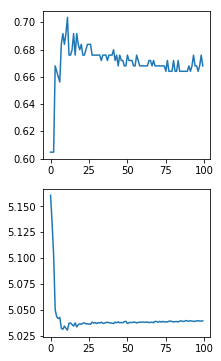

In [27]:
plt.figure(figsize=(3,6))

# accuracy
plt.subplot(211)
plt.plot(accuracy)

# loss
plt.subplot(212)
plt.plot(np.log(_loss))

plt.show()

# Conclusion
With current settings the deep neural network performs with accuracy close to 70%. This number could be potentially further increased by introducing more data (more features or larger training dataset) or by tweaking Model parameters.